In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.autonotebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, HTML, clear_output

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters, find_hyperparameters, test_already_stored
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]
pd.options.display.max_rows = 200

/tmp/ipykernel_2847334/3130838648.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
params_dict = {}

# Dataset Params - dataset.____ keys are passed into DatasetHandler constructor
params_dict["dataset.name"] = ["smsm", "kinetics_100", "moma_act", "moma_sact"]
params_dict["dataset.split"] = ["val"]
params_dict["dataset.split_type"] = ["video"]

# Few-Shot Test Params - test.____ keys are passed into few-shot test call
params_dict["test.n_way"] = [None] # None gets converted into the max value for each dataset
params_dict["test.n_support"] = [0, 1, 2, 4, 8, 16]
params_dict["test.n_query"] = [None]
params_dict["test.n_episodes"] = [4]

# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    params_dict["vlm.num_frames"] = [10]
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    params_dict["vlm.num_seconds"] = [4]
    params_dict["vlm.sample_strat"] = ["spread"]
    params_dict["vlm.use_cuda"] = [True]
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
else:
    raise NotImplementedError

# Classifier Params - classifier.____ keys are passed into classifier constructor
if False:
    from classifier import WeightedTextFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    #params_dict["classifier.metric"] = [Similarity.COSINE, Similarity.DOT, Similarity.EUCLID]
if True:
    from classifier import HardPromptFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0]
    params_dict["classifier.prompt_text"] = [
        "",
        "a photo showing the task of",
        "an activity of",
        "the video shows me"
    ]
if False:
    from classifier import NearestNeighborFewShotClassifier as Classifier
    params_dict["classifier.neighbor_count"] = [1, 2, 3, 4, 5, 10, 20]
    params_dict["classifier.neighbor_weights"] = ["uniform", "distance"]
if False:
    from classifier import GaussianFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prior_count"] = [0, 1, 3, 10, 30, 100]
    params_dict["classifier.prior_var"] = [0, 1, 3, 10, 30, 100]
if False:
    from classifier import SubVideoAverageFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.subvideo_segment_duration"] = [1, 2, 5]
    params_dict["classifier.subvideo_max_segments"] = [32]
    params_dict["classifier.subvideo_discard_proportion"] = [0, 0.1, 0.25, 0.5]
if False:
    from classifier import TipAdapterFewShotClassifier as Classifier
    params_dict["classifier.alpha"] = [858]#[238]#[100, 120, 140] #[0.5, 1.0, 2.0]
    params_dict["classifier.beta"] = [26]#[5.07] #[2.5, 5.5, 10.0]
    params_dict["classifier.finetune_lr"] = [0]#[5.9e-4]#[1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    params_dict["classifier.finetune_epochs"] = [0]#[10] #[0, 1, 5, 10, 20]
if False:
    from classifier.smsm_object_oracle import SmsmObjectOracleFewShotClassifier as Classifier
if False:
    from classifier.coop import CoopFewShotClassifier as Classifier
    params_dict["classifier.lr"] = [2e-4]#, 2e-3, 1e-2]
    params_dict["classifier.epochs"] = [10]
    params_dict["classifier.warmup_epochs"] = [1]
    params_dict["classifier.random_augment"] = [True]
    params_dict["classifier.batch_size"] = [8]
if False:
    from classifier.cona import CoNaFewShotClassifier as Classifier
    params_dict["classifier.batch_size"] = [8]
    params_dict["classifier.random_augment"] = [True]

In [4]:
TEST_FILENAME = "vl_proto.csv"
test_handler = FewShotTestHandler(TEST_FILENAME)

In [5]:
vlm = None
cur_vlm_params = None
classifier = None
cur_classifier_params = None
query_dataset = None
support_dataset = None
cur_dataset_params = None

pbar = tqdm(list(itertools.product(*params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(params_dict.keys(), params))
    
    pbar.set_postfix(params)
    
    # vlm params
    vlm_params = {key[4:]: val for key, val in params.items() if key.startswith("vlm.")}
    classifier_params = {key[11:]: val for key, val in params.items() if key.startswith("classifier.")}
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    # Update dataset
    if query_dataset is None or cur_dataset_params != dataset_params:
        query_dataset = DatasetHandler(**dataset_params)
        support_dataset_params = dict(dataset_params, split="train")
        support_dataset = DatasetHandler(**support_dataset_params)
        
        cur_dataset_params = dataset_params
        new_dataset = True
    else:
        new_dataset = False
        
    # Convert n_way = None into n_way = max-ways
    if test_params["n_way"] is None:
        test_params["n_way"] = support_dataset.category_count()
    
    # Update vlm (which forces update of classifier)
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        
        cur_vlm_params = vlm_params
        new_vlm = True
    else:
        new_vlm = False
            
    if new_vlm or classifier is None or cur_classifier_params != classifier_params:
        classifier = Classifier(vlm, **classifier_params)
        cur_classifier_params = classifier_params
        
    # Fill dataset caches
    if new_dataset or new_vlm:
        query_dataset.fill_cache(vlm)
        support_dataset.fill_cache(vlm)
    
    # Run test
    test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, **test_params)
    
clear_output()

In [6]:
display(test_handler.results)

,vlm_class,vlm.num_frames,vlm.num_seconds,vlm.path,vlm.sample_strat,vlm.use_cuda,classifier_class,classifier.metric,classifier.prompt_location,classifier.prompt_text,classifier.text_weight,query_dataset,support_dataset,n_way,n_support,n_query,n_episodes,val_tuning_dataset,accuracy,accuracy_std
0,VideoClipVLM,NaN,4.0,video_clip/MMPT_updated/projects/retri/videocl...,spread,True,HardPromptFewShotClassifier,DOT,start,NaN,0.0,smsm.v.val,smsm.v.train,100,1,NaN,4,NaN,0.050227,0.006599
1,VideoClipVLM,NaN,4.0,video_clip/MMPT_updated/projects/retri/videocl...,spread,True,HardPromptFewShotClassifier,DOT,start,a photo showing the task of,0.0,smsm.v.val,smsm.v.train,100,1,NaN,4,NaN,0.050227,0.006599
2,VideoClipVLM,NaN,4.0,video_clip/MMPT_updated/projects/retri/videocl...,spread,True,HardPromptFewShotClassifier,DOT,start,an activity of,0.0,smsm.v.val,smsm.v.train,100,1,NaN,4,NaN,0.050227,0.006599
3,VideoClipVLM,NaN,4.0,video_clip/MMPT_updated/projects/retri/videocl...,spread,True,HardPromptFewShotClassifier,DOT,start,the video shows me,0.0,smsm.v.val,smsm.v.train,100,1,NaN,4,NaN,0.050227,0.006599
4,VideoClipVLM,NaN,4.0,video_clip/MMPT_updated/projects/retri/videocl...,spread,True,HardPromptFewShotClassifier,DOT,start,NaN,0.1,smsm.v.val,smsm.v.train,100,1,NaN,4,NaN,0.051591,0.007589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,MILES_SimilarityVLM,NaN,NaN,NaN,NaN,NaN,HardPromptFewShotClassifier,COSINE,start,the video shows me,50.0,moma_sact.v.val,moma_sact.v.train,80,16,NaN,4,NaN,0.417718,0.011338
4073,MILES_SimilarityVLM,NaN,NaN,NaN,NaN,NaN,HardPromptFewShotClassifier,COSINE,start,,100.0,moma_sact.v.val,moma_sact.v.train,80,16,NaN,4,NaN,0.361621,0.008023
4074,MILES_SimilarityVLM,NaN,NaN,NaN,NaN,NaN,HardPromptFewShotClassifier,COSINE,start,a photo showing the task of,100.0,moma_sact.v.val,moma_sact.v.train,80,16,NaN,4,NaN,0.400803,0.005075
4075,MILES_SimilarityVLM,NaN,NaN,NaN,NaN,NaN,HardPromptFewShotClassifier,COSINE,start,an activity of,100.0,moma_sact.v.val,moma_sact.v.train,80,16,NaN,4,NaN,0.391055,0.003716


### Run Best Hyperparameters on Test Split

In [7]:
best_hyperparam_values = find_hyperparameters(
    test_handler.results,
    hyperparam_cols=[col for col in test_handler.results if col.startswith("classifier.") or col.startswith("vlm.")]
)
display(best_hyperparam_values)

,vlm_class,classifier_class,query_dataset,support_dataset,n_way,n_support,n_query,n_episodes,val_tuning_dataset,vlm.num_frames,vlm.num_seconds,vlm.path,vlm.sample_strat,vlm.use_cuda,classifier.metric,classifier.prompt_location,classifier.prompt_text,classifier.text_weight
577,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,16,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,a photo showing the task of,6.0
1861,MILES_SimilarityVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,16,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,COSINE,start,the video shows me,1.0
1770,MILES_SimilarityVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,8,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,COSINE,start,,1.0
524,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,8,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,a photo showing the task of,4.0
489,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,4,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,an activity of,20.0
424,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,2,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,a photo showing the task of,20.0
1719,MILES_SimilarityVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,4,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,COSINE,start,,2.0
384,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,1,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,an activity of,10.0
1667,MILES_SimilarityVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,2,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,COSINE,start,,2.0
332,ClipVLM,HardPromptFewShotClassifier,moma_act.v.val,moma_act.v.train,19,0,NaN,4,NaN,10.0,NaN,openai/clip-vit-base-patch32,uniform,NaN,COSINE,start,an activity of,10.0


In [8]:
# Change params_dict to only include dataset and test info, then run tests with best hyperparameter values
test_split_params_dict = {
    "dataset.split": ["test"]
}
for key, val in params_dict.items():
    if key.startswith("classifier.") or key.startswith("vlm.") or key == "dataset.split":
        continue
    test_split_params_dict[key] = val
    
final_test_handler = FewShotTestHandler(f"test.{TEST_FILENAME}")
    
vlm = None
cur_vlm_params = None
classifier = None
cur_classifier_params = None
query_dataset = None
support_dataset = None
cur_dataset_params = None

pbar = tqdm(list(itertools.product(*test_split_params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(test_split_params_dict.keys(), params))
    
    # Determine dataset and test parameters
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    # Update dataset
    if query_dataset is None or cur_dataset_params != dataset_params:
        query_dataset = DatasetHandler(**dataset_params)
        support_dataset_params = dict(dataset_params, split="train")
        support_dataset = DatasetHandler(**support_dataset_params)
        
        # Construct dummy val dataset to get id for filtering dataframe results with corresponding hyperparameters
        val_dataset = DatasetHandler(**dict(dataset_params, split="val"))
        
        cur_dataset_params = dataset_params
        new_dataset = True
    else:
        new_dataset = False
        
    # Convert n_way = None into n_way = max-ways
    if test_params["n_way"] is None:
        test_params["n_way"] = support_dataset.category_count()
        
    # Determine vlm and classifier params from hyperparameter dataframe
    matched_hyperparam_values = np.ones(len(best_hyperparam_values)).astype(bool)
    matched_hyperparam_values &= (best_hyperparam_values["vlm_class"] == VLM.__name__) & (best_hyperparam_values["classifier_class"] == Classifier.__name__)
    matched_hyperparam_values &= (best_hyperparam_values["query_dataset"] == val_dataset.id()) & (best_hyperparam_values["support_dataset"] == support_dataset.id())
    for col, val in test_params.items():
        if pd.isna(val):
            matched_hyperparam_values &= pd.isna(best_hyperparam_values[col])        
        else:
            matched_hyperparam_values &= (best_hyperparam_values[col] == val)
    matched_hyperparam_values = best_hyperparam_values[matched_hyperparam_values].reset_index(drop=True)
    
    vlm_params = {}
    classifier_params = {}
    for col in matched_hyperparam_values.columns:
        if col.startswith("vlm."):
            val = matched_hyperparam_values.loc[0, col]
            if not pd.isna(val):
                vlm_params[col[4:]] = val
        
        if col.startswith("classifier."):
            val = matched_hyperparam_values.loc[0, col]
            if not pd.isna(val):
                if col != "classifier.metric":
                    classifier_params[col[11:]] = val
                else:
                    classifier_params[col[11:]] = Similarity[val]
        
    for key, val in vlm_params.items():
        params[f"vlm.{key}"] = val
    for key, val in classifier_params.items():
        params[f"classifier.{key}"] = val
    pbar.set_postfix(params)
    
    
    
    # Update vlm (which forces update of classifier)
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        
        cur_vlm_params = vlm_params
        new_vlm = True
    else:
        new_vlm = False
            
    if new_vlm or classifier is None or cur_classifier_params != classifier_params:
        classifier = Classifier(vlm, **classifier_params)
        cur_classifier_params = classifier_params
        
    # Fill dataset caches
    if new_dataset or new_vlm:
        query_dataset.fill_cache(vlm)
        support_dataset.fill_cache(vlm)
    
    # Run test
    final_test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, **test_params)
    
clear_output()

In [13]:
display(final_test_handler.results.sort_values(["query_dataset", "n_support", "vlm_class"])[["query_dataset", "n_support", "vlm_class", "accuracy"]])

,query_dataset,n_support,vlm_class,accuracy
30,kinetics_100.v.test,0,ClipVLM,0.711538
54,kinetics_100.v.test,0,MILES_SimilarityVLM,0.546154
6,kinetics_100.v.test,0,VideoClipVLM,0.355385
31,kinetics_100.v.test,1,ClipVLM,0.714423
55,kinetics_100.v.test,1,MILES_SimilarityVLM,0.592308
7,kinetics_100.v.test,1,VideoClipVLM,0.422308
32,kinetics_100.v.test,2,ClipVLM,0.720000
56,kinetics_100.v.test,2,MILES_SimilarityVLM,0.612692
8,kinetics_100.v.test,2,VideoClipVLM,0.432500
33,kinetics_100.v.test,4,ClipVLM,0.721538


12 Overall Lines
4 Separate Plots


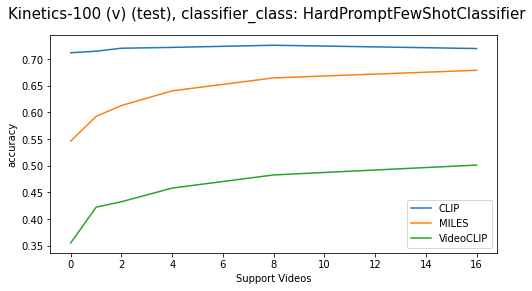

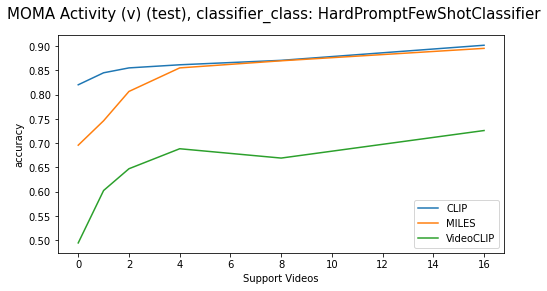

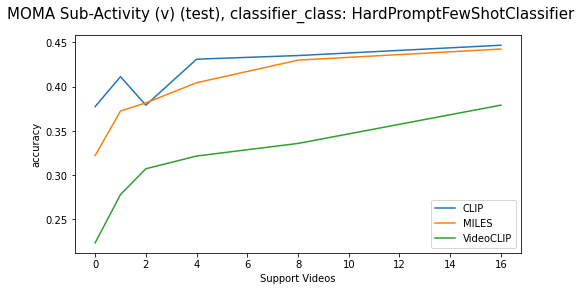

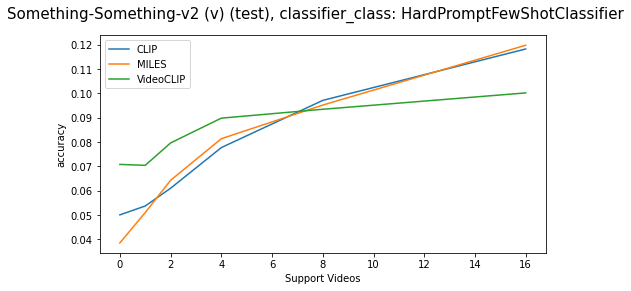

In [11]:
plot(
    final_test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["query_dataset", "classifier_class"],
    line_descriptor_cols=["vlm_class"]
)